In [1]:
import cupy as cp
from cupy.fft import fft2, ifft2
import numpy as np
import matplotlib.pyplot as plt

print("CuPy version:", cp.__version__)
print("GPU:", cp.cuda.runtime.getDeviceProperties(0)['name'].decode())

import time
def sync_gpu():
    cp.cuda.Stream.null.synchronize()

CuPy version: 13.6.0
GPU: NVIDIA GeForce GTX 1650 Ti with Max-Q Design


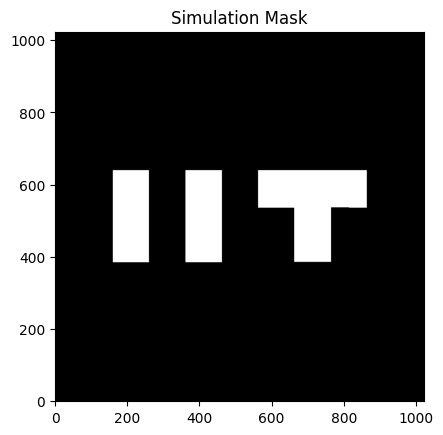

In [2]:
import gdstk
from skimage.draw import polygon

# LOAD AND RASTERIZE GDS

gds_path = r"C:/Users/USER/Documents/Phd/Test_Patterns-20260102T051200Z-3-001/Test_Patterns/pattern2_100_new.gds"

lib = gdstk.read_gds(gds_path)
top_cell = lib.top_level()[0]

polygons = top_cell.get_polygons()

MASK_LAYER = 1
MASK_DATATYPE = 0

mask_polys = [p for p in polygons if p.layer == MASK_LAYER and p.datatype == MASK_DATATYPE]

pixel_size_nm = 1.0
scale_factor = 1000.0

bbox = top_cell.bounding_box()
min_x_um, min_y_um = bbox[0]
max_x_um, max_y_um = bbox[1]

width_um = max_x_um - min_x_um
height_um = max_y_um - min_y_um

img_width = int(np.ceil(round(width_um,5) * scale_factor))
img_height = int(np.ceil(round(height_um,5) * scale_factor))

raw_mask = np.zeros((img_height, img_width), dtype=np.float64)

for poly in mask_polys:
    poly_shifted = (poly.points - [min_x_um, min_y_um]) * scale_factor
    rr, cc = polygon(poly_shifted[:,1], poly_shifted[:,0], shape=raw_mask.shape)
    raw_mask[rr,cc] = 1.0

N_sim = 1024
if img_width > N_sim or img_height > N_sim:
    N_sim = 2048

mask_cpu = np.zeros((N_sim,N_sim), dtype=np.float64)

start_y = (N_sim - img_height)//2
start_x = (N_sim - img_width)//2

mask_cpu[start_y:start_y+img_height,
         start_x:start_x+img_width] = raw_mask

plt.imshow(mask_cpu, cmap="gray", origin="lower")
plt.title("Simulation Mask")
plt.show()

# Move to GPU
mask = cp.asarray(mask_cpu)
z_target = mask.copy()

In [3]:
# GPU utility functions
def resist_sigmoid(I, threshold, a):
    return 1.0 / (1.0 + cp.exp(-a * (I - threshold)))

def sigmoid_derivative(z, a):
    return a * z * (1.0 - z)

def h_to_mask(h):
    return 0.5 * (1.0 + cp.cos(h))

def dh_dm(h):
    return -0.5 * cp.sin(h)

In [4]:
# Optical System Definition

threshold = cp.float64(0.25)
a_sigmoid = cp.float64(30.0)

wavelength = 193.0   # nm
NA = 1.35
dx = 1.0             # pixel size in nm

N_sim = mask.shape[0]
L_nm = N_sim * dx

# Frequency grid
fx = cp.fft.fftfreq(N_sim, d=dx)
fy = cp.fft.fftfreq(N_sim, d=dx)
FX, FY = cp.meshgrid(fx, fy)

freq_radius = cp.sqrt(FX**2 + FY**2)

f_cutoff = NA / wavelength

pupil = cp.zeros_like(freq_radius)
pupil[freq_radius <= f_cutoff] = 1.0

print("Pupil constructed.")

Pupil constructed.


In [5]:
# GPU forward model
def forward_model(mask, pupil):
    field = ifft2(fft2(mask) * pupil)
    intensity = cp.abs(field)**2
    return field, intensity

In [6]:
print("\n--- Initial Forward Model (GPU) ---")

start = time.time()

field_init, I_init = forward_model(mask, pupil)
z_init = resist_sigmoid(I_init, threshold, a_sigmoid)

sync_gpu()
gpu_aerial_time = time.time() - start

print("GPU Aerial Runtime:", gpu_aerial_time, "seconds")


--- Initial Forward Model (GPU) ---
GPU Aerial Runtime: 0.02766704559326172 seconds


In [7]:
# aerial cost and gradident (Step 1)
def aerial_cost(mask, pupil, z_target):
    field = ifft2(fft2(mask) * pupil)
    aerial = cp.abs(field)**2
    return cp.sum((z_target - aerial)**2)

def aerial_gradient(mask, pupil, z_target):
    field = ifft2(fft2(mask) * pupil)
    aerial = cp.abs(field)**2

    error = z_target - aerial
    temp = error * cp.conj(field)

    grad = -2 * cp.real(ifft2(fft2(temp) * pupil))
    return grad

In [8]:
# ILT cost gradient (Step 2)
def ilt_gradient(mask, pupil, z_target, threshold, a):
    
    field = ifft2(fft2(mask) * pupil)
    intensity = cp.abs(field)**2
    
    z = resist_sigmoid(intensity, threshold, a)
    error = z - z_target
    
    dz_dI = sigmoid_derivative(z, a)
    
    temp = error * dz_dI * cp.conj(field)
    
    grad = 2 * cp.real(ifft2(fft2(temp) * pupil))
    return grad

In [9]:
# Phase 1 Step 1
total_start_time = time.perf_counter()
step1_start = time.perf_counter()

print("\n--- STEP 1 (GPU) ---")

m = mask.copy()

step1_iters = 80
step1_stepsize = 0.06

for itr in range(step1_iters):

    grad = aerial_gradient(m, pupil, z_target)
    m -= step1_stepsize * grad
    m = cp.clip(m, 0.0, 1.0)

    if itr % 5 == 0:
        cost = aerial_cost(m, pupil, z_target)
        print(f"[Step1] Iter {itr:03d} | Cost = {float(cost):.4e}")

sync_gpu()
step1_end = time.perf_counter()
step1_time = step1_end - step1_start
print(f"\nSTEP-1 Time (GPU): {step1_time:.4f} sec")

mask_step1 = m.copy()


--- STEP 1 (GPU) ---
[Step1] Iter 000 | Cost = 1.8801e+04
[Step1] Iter 005 | Cost = 1.7863e+04
[Step1] Iter 010 | Cost = 1.7126e+04
[Step1] Iter 015 | Cost = 1.6516e+04
[Step1] Iter 020 | Cost = 1.6008e+04
[Step1] Iter 025 | Cost = 1.5589e+04
[Step1] Iter 030 | Cost = 1.5246e+04
[Step1] Iter 035 | Cost = 1.4966e+04
[Step1] Iter 040 | Cost = 1.4739e+04
[Step1] Iter 045 | Cost = 1.4556e+04
[Step1] Iter 050 | Cost = 1.4409e+04
[Step1] Iter 055 | Cost = 1.4292e+04
[Step1] Iter 060 | Cost = 1.4197e+04
[Step1] Iter 065 | Cost = 1.4121e+04
[Step1] Iter 070 | Cost = 1.4060e+04
[Step1] Iter 075 | Cost = 1.4010e+04

STEP-1 Time (GPU): 1.2175 sec


In [10]:
# convert to h domain
h = cp.arccos(2.0 * mask_step1 - 1.0)

In [11]:
# step 2 optimization
step2_start = time.perf_counter()

print("\n--- STEP 2 (GPU) ---")

num_iters = 100
step_size = 10.0

for itr in range(num_iters):

    m = h_to_mask(h)

    z_field, intensity = forward_model(m, pupil)
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    cost = cp.sum((z - z_target)**2)

    grad_m = ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
    grad_h = grad_m * dh_dm(h)

    h -= step_size * grad_h

    if itr % 5 == 0:
        print(f"[Step2] Iter {itr:03d} | Cost = {float(cost):.4e}")

h_step2 = h.copy()

sync_gpu()
step2_end = time.perf_counter()
step2_time = step2_end - step2_start
print(f"\nSTEP-2 Time (GPU): {step2_time:.4f} sec")


--- STEP 2 (GPU) ---
[Step2] Iter 000 | Cost = 1.9768e+04
[Step2] Iter 005 | Cost = 6.7955e+03
[Step2] Iter 010 | Cost = 5.8586e+03
[Step2] Iter 015 | Cost = 5.3021e+03
[Step2] Iter 020 | Cost = 5.0241e+03
[Step2] Iter 025 | Cost = 4.8388e+03
[Step2] Iter 030 | Cost = 4.7149e+03
[Step2] Iter 035 | Cost = 4.6121e+03
[Step2] Iter 040 | Cost = 4.5302e+03
[Step2] Iter 045 | Cost = 4.4624e+03
[Step2] Iter 050 | Cost = 4.4075e+03
[Step2] Iter 055 | Cost = 4.3625e+03
[Step2] Iter 060 | Cost = 4.3260e+03
[Step2] Iter 065 | Cost = 4.2951e+03
[Step2] Iter 070 | Cost = 4.2696e+03
[Step2] Iter 075 | Cost = 4.2468e+03
[Step2] Iter 080 | Cost = 4.2278e+03
[Step2] Iter 085 | Cost = 4.2110e+03
[Step2] Iter 090 | Cost = 4.1965e+03
[Step2] Iter 095 | Cost = 4.1834e+03

STEP-2 Time (GPU): 2.4692 sec


In [12]:
mask_phase1 = h_to_mask(h_step2)

field_p1, I_p1 = forward_model(mask_phase1, pupil)
z_p1 = resist_sigmoid(I_p1, threshold, a_sigmoid)

print("Phase-1 mask saved.")

Phase-1 mask saved.


In [13]:
# regularization terms
def discretization_penalty(mask):
    return cp.sum(4 * mask * (1 - mask))

def discretization_gradient(mask):
    return 4 * (1 - 2 * mask)

def tv_gradient(mask):

    dx = cp.roll(mask, -1, axis=1) - mask
    dy = cp.roll(mask, -1, axis=0) - mask

    grad = (
        dx - cp.roll(dx, 1, axis=1)
        + dy - cp.roll(dy, 1, axis=0)
    )

    return grad

In [14]:
phase2_start = time.perf_counter()

print("\n--- Phase 2 ---")

cfid = 1.0
caerial = 0.25
step = 5.0
iters = 100

for itr in range(iters):

    m = h_to_mask(h)
    field, intensity = forward_model(m, pupil)
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F = cp.sum((z - z_target)**2)
    Ra = aerial_cost(m, pupil, z_target)

    grad = (
        cfid * ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_gradient(m, pupil, z_target)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 10 == 0:
        total = cfid*F + caerial*Ra
        print(f"[PH2] Iter {itr:03d} | Total = {float(total):.4e}")

sync_gpu()
phase2_end = time.perf_counter()
phase2_time = phase2_end - phase2_start
print(f"\nPhase-2 Time (GPU): {phase2_time:.4f} sec")


--- Phase 2 ---
[PH2] Iter 000 | Total = 9.3213e+03
[PH2] Iter 010 | Total = 9.2436e+03
[PH2] Iter 020 | Total = 9.2198e+03
[PH2] Iter 030 | Total = 9.2037e+03
[PH2] Iter 040 | Total = 9.1913e+03
[PH2] Iter 050 | Total = 9.1817e+03
[PH2] Iter 060 | Total = 9.1740e+03
[PH2] Iter 070 | Total = 9.1676e+03
[PH2] Iter 080 | Total = 9.1620e+03
[PH2] Iter 090 | Total = 9.1571e+03

Phase-2 Time (GPU): 4.5816 sec


In [15]:
phase3_start = time.perf_counter()

print("\n--- Phase 3 ---")

cdis = 0.005
step = 3.0
iters = 80

for itr in range(iters):

    m = h_to_mask(h)
    field, intensity = forward_model(m, pupil)
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F = cp.sum((z - z_target)**2)
    Ra = aerial_cost(m, pupil, z_target)
    Rd = discretization_penalty(m)

    grad = (
        ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_gradient(m, pupil, z_target)
        + cdis * discretization_gradient(m)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 10 == 0:
        total = F + caerial*Ra + cdis*Rd
        print(f"[PH3] Iter {itr:03d} | Total = {float(total):.4e}")

sync_gpu()
phase3_end = time.perf_counter()
phase3_time = phase3_end - phase3_start
print(f"\nPhase-3 Time (GPU): {phase3_time:.4f} sec")


--- Phase 3 ---
[PH3] Iter 000 | Total = 9.5357e+03
[PH3] Iter 010 | Total = 9.4653e+03
[PH3] Iter 020 | Total = 9.4042e+03
[PH3] Iter 030 | Total = 9.3515e+03
[PH3] Iter 040 | Total = 9.3071e+03
[PH3] Iter 050 | Total = 9.2706e+03
[PH3] Iter 060 | Total = 9.2412e+03
[PH3] Iter 070 | Total = 9.2179e+03

Phase-3 Time (GPU): 3.7455 sec


In [16]:
phase4_start = time.perf_counter()

print("\n--- Phase 4 ---")

cTV = 0.005
step = 1.5
iters = 80

for itr in range(iters):

    m = h_to_mask(h)
    field, intensity = forward_model(m, pupil)
    z = resist_sigmoid(intensity, threshold, a_sigmoid)

    F = cp.sum((z - z_target)**2)
    Ra = aerial_cost(m, pupil, z_target)
    Rd = discretization_penalty(m)
    Rt = cp.sum(cp.abs(tv_gradient(m)))

    grad = (
        ilt_gradient(m, pupil, z_target, threshold, a_sigmoid)
        + caerial * aerial_gradient(m, pupil, z_target)
        + cdis * discretization_gradient(m)
        + cTV * tv_gradient(m)
    )

    grad_h = grad * dh_dm(h)
    h -= step * grad_h

    if itr % 10 == 0:
        total = F + caerial*Ra + cdis*Rd + cTV*Rt
        print(f"[PH4] Iter {itr:03d} | Total = {float(total):.4e}")

sync_gpu()
phase4_end = time.perf_counter()
phase4_time = phase4_end - phase4_start
print(f"\nPhase-4 Time (GPU): {phase4_time:.4f} sec")


--- Phase 4 ---
[PH4] Iter 000 | Total = 9.3000e+03
[PH4] Iter 010 | Total = 9.2954e+03
[PH4] Iter 020 | Total = 9.2917e+03
[PH4] Iter 030 | Total = 9.2887e+03
[PH4] Iter 040 | Total = 9.2864e+03
[PH4] Iter 050 | Total = 9.2846e+03
[PH4] Iter 060 | Total = 9.2832e+03
[PH4] Iter 070 | Total = 9.2822e+03

Phase-4 Time (GPU): 4.0112 sec


In [17]:
mask_phase4 = h_to_mask(h)

field_p4, I_p4 = forward_model(mask_phase4, pupil)
z_p4 = resist_sigmoid(I_p4, threshold, a_sigmoid)

print("Phase-4 mask saved.")

Phase-4 mask saved.


In [18]:
sync_gpu()
total_end_time = time.perf_counter()
total_time = total_end_time - total_start_time

print("\n=================================")
print("GPU EXECUTION TIME SUMMARY")
print("=================================")
print(f"STEP-1   : {step1_time:.4f} sec")
print(f"STEP-2   : {step2_time:.4f} sec")
print(f"Phase-2  : {phase2_time:.4f} sec")
print(f"Phase-3  : {phase3_time:.4f} sec")
print(f"Phase-4  : {phase4_time:.4f} sec")
print("---------------------------------")
print(f"TOTAL    : {total_time:.4f} sec")


GPU EXECUTION TIME SUMMARY
STEP-1   : 1.2175 sec
STEP-2   : 2.4692 sec
Phase-2  : 4.5816 sec
Phase-3  : 3.7455 sec
Phase-4  : 4.0112 sec
---------------------------------
TOTAL    : 16.0828 sec


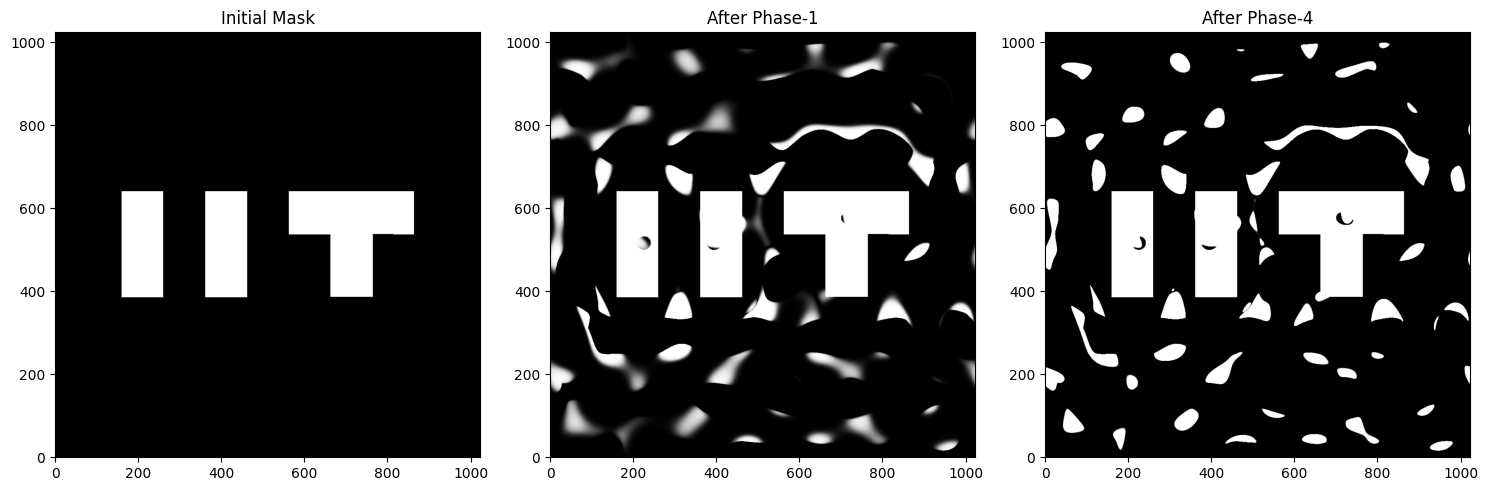

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cp.asnumpy(mask), cmap="gray", origin="lower")
plt.title("Initial Mask")

plt.subplot(1,3,2)
plt.imshow(cp.asnumpy(mask_phase1), cmap="gray", origin="lower")
plt.title("After Phase-1")

plt.subplot(1,3,3)
plt.imshow(cp.asnumpy(mask_phase4), cmap="gray", origin="lower")
plt.title("After Phase-4")

plt.tight_layout()
plt.show()

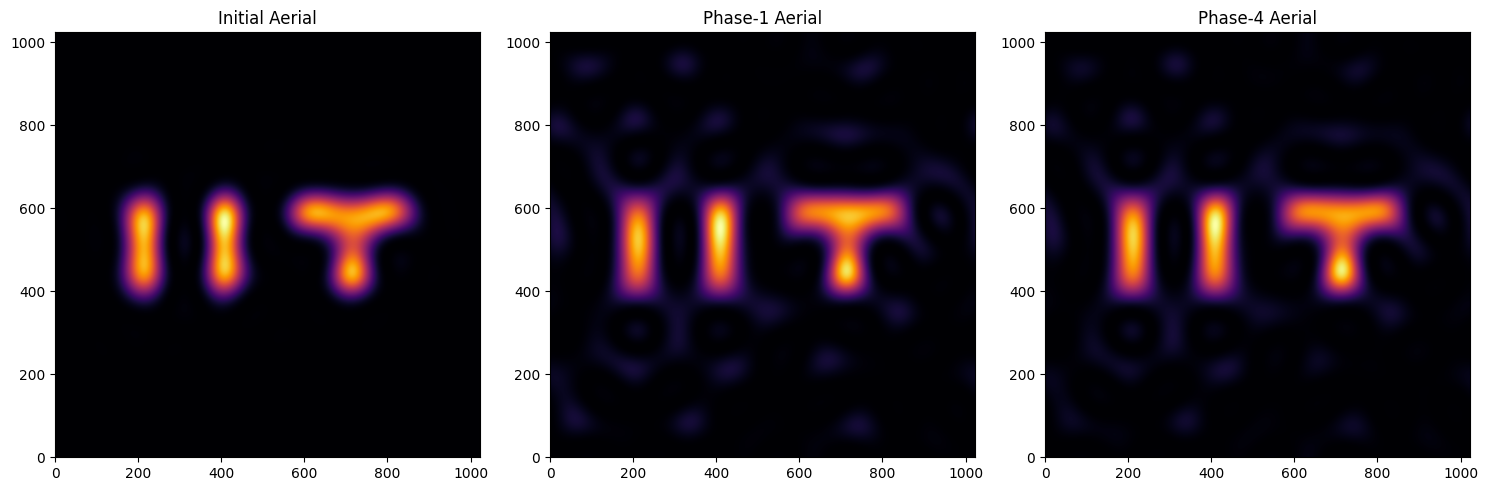

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cp.asnumpy(I_init), cmap="inferno", origin="lower")
plt.title("Initial Aerial")

plt.subplot(1,3,2)
plt.imshow(cp.asnumpy(I_p1), cmap="inferno", origin="lower")
plt.title("Phase-1 Aerial")

plt.subplot(1,3,3)
plt.imshow(cp.asnumpy(I_p4), cmap="inferno", origin="lower")
plt.title("Phase-4 Aerial")

plt.tight_layout()
plt.show()

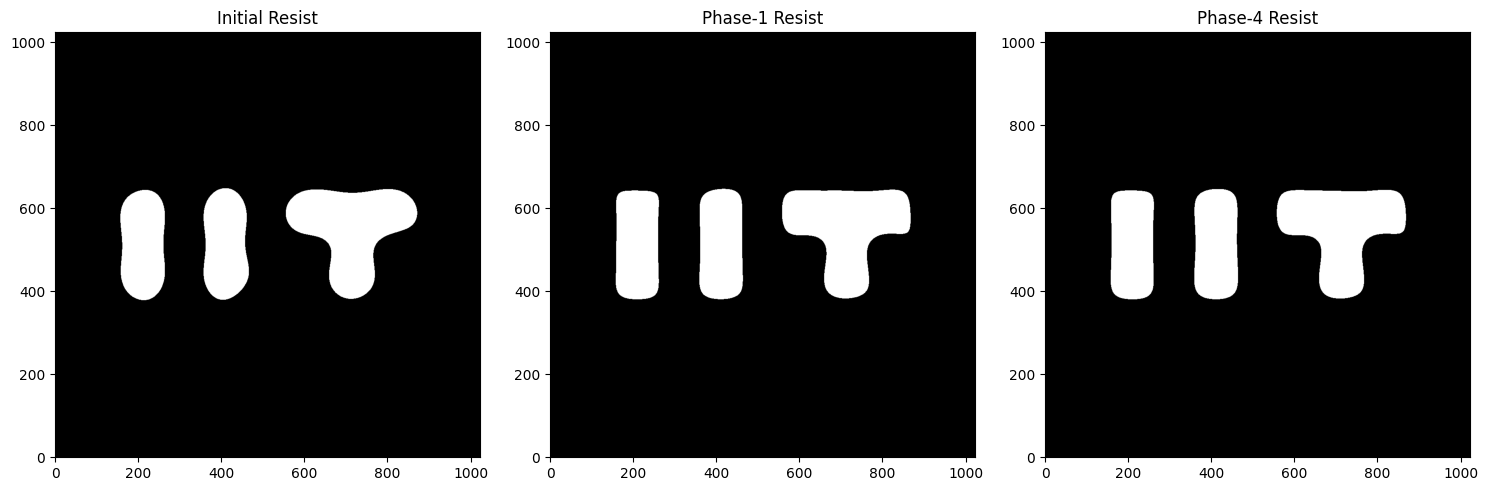

In [21]:
binary_resist = cp.zeros_like(z_init)
binary_resist[z_init >= 0.5] = 1.0

binary_resistp1 = cp.zeros_like(z_init)
binary_resistp1[z_p1 >= 0.5] = 1.0

binary_resistp4 = cp.zeros_like(z_init)
binary_resistp4[z_p4 >= 0.5] = 1.0

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(cp.asnumpy(binary_resist), cmap="gray", origin="lower")
plt.title("Initial Resist")

plt.subplot(1,3,2)
plt.imshow(cp.asnumpy(binary_resistp1), cmap="gray", origin="lower")
plt.title("Phase-1 Resist")

plt.subplot(1,3,3)
plt.imshow(cp.asnumpy(binary_resistp4), cmap="gray", origin="lower")
plt.title("Phase-4 Resist")

plt.tight_layout()
plt.show()
